# Decision Trees

In [21]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

## HS CIGAR USE

/var/folders/9q/yldjq0js2ng8cysrh56tt9xw0000gn/T/ipykernel_32398/3690012490.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Mean Squared Error: 2.6928005600305704
Accuracy: 0.8625397016602759


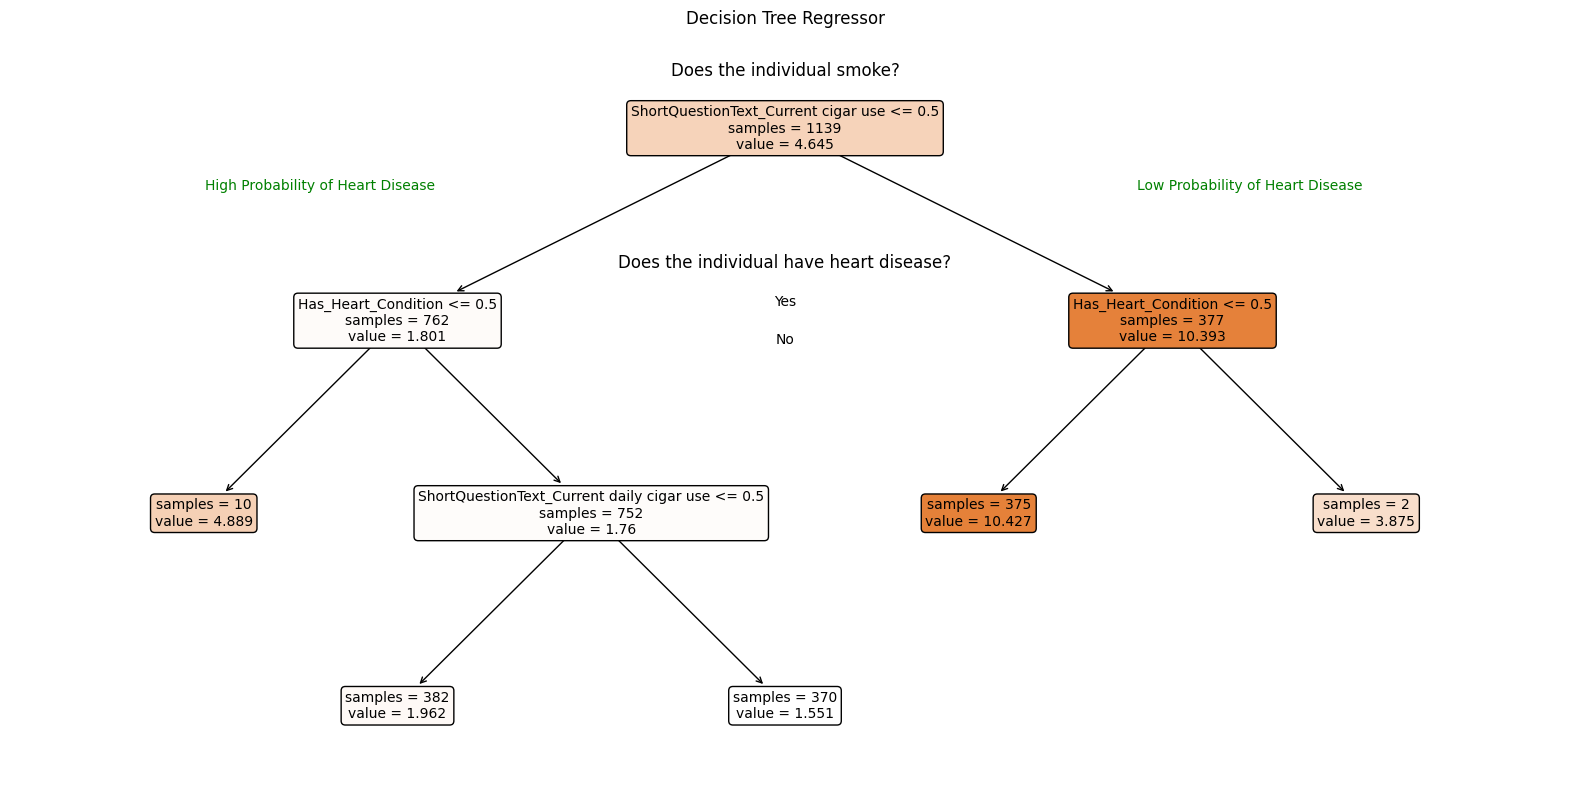

In [26]:
# Connect to MySQL database
conn = mysql.connector.connect(
    host="localhost",
    user="monty",
    password="sushiSQL",
    database="HealthCareAnalytics"
)

# Read the data from the MySQL table into a pandas DataFrame
query = "SELECT * FROM cdc_cigar_use"
df = pd.read_sql(query, conn)
conn.close()

# Filter the data based on smoking habits and heart condition
df_encoded = pd.get_dummies(df, columns=['ShortQuestionText'])
df_encoded['Has_Heart_Condition'] = df_encoded['Lesser_Risk_Low_Confidence_Limit'] > 95.5

# Define features and target variable
X = df_encoded[['ShortQuestionText_Current daily cigar use',
                'ShortQuestionText_Current cigar use',
                'ShortQuestionText_Frequent cigar use',
                'Has_Heart_Condition']]
y = df_encoded['Greater_Risk_High_Confidence_Limit']  # Target variable for regression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate and print the accuracy
accuracy = 1 - mse / np.var(y_test)
print(f"Accuracy: {accuracy}")

# Plot the decision tree with customized labels and colors
plt.figure(figsize=(20, 10))  # Adjust figsize as needed for better visualization
plot_tree(
    model,
    filled=True,
    feature_names=X.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    rounded=True,
    fontsize=10,
    label='all',
    impurity=False,
    proportion=False,
)
# Customize the labels manually for better readability
plt.text(0.5, 0.95, 'Does the individual smoke?', ha='center', va='center', fontsize=12, color='black', transform=plt.gca().transAxes)
plt.text(0.5, 0.9, 'Yes', ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transAxes)
plt.text(0.5, 0.85, 'No', ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transAxes)

plt.text(0.2, 0.8, 'High Probability of Heart Disease', ha='center', va='center', fontsize=10, color='green', transform=plt.gca().transAxes)
plt.text(0.8, 0.8, 'Low Probability of Heart Disease', ha='center', va='center', fontsize=10, color='green', transform=plt.gca().transAxes)

plt.text(0.5, 0.7, 'Does the individual have heart disease?', ha='center', va='center', fontsize=12, color='black', transform=plt.gca().transAxes)
plt.text(0.5, 0.65, 'Yes', ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transAxes)
plt.text(0.5, 0.6, 'No', ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transAxes)

plt.title("Decision Tree Regressor")
plt.show()

## CMS Chronic Conditions

/var/folders/9q/yldjq0js2ng8cysrh56tt9xw0000gn/T/ipykernel_32398/3192852901.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Accuracy: 0.7792207792207793


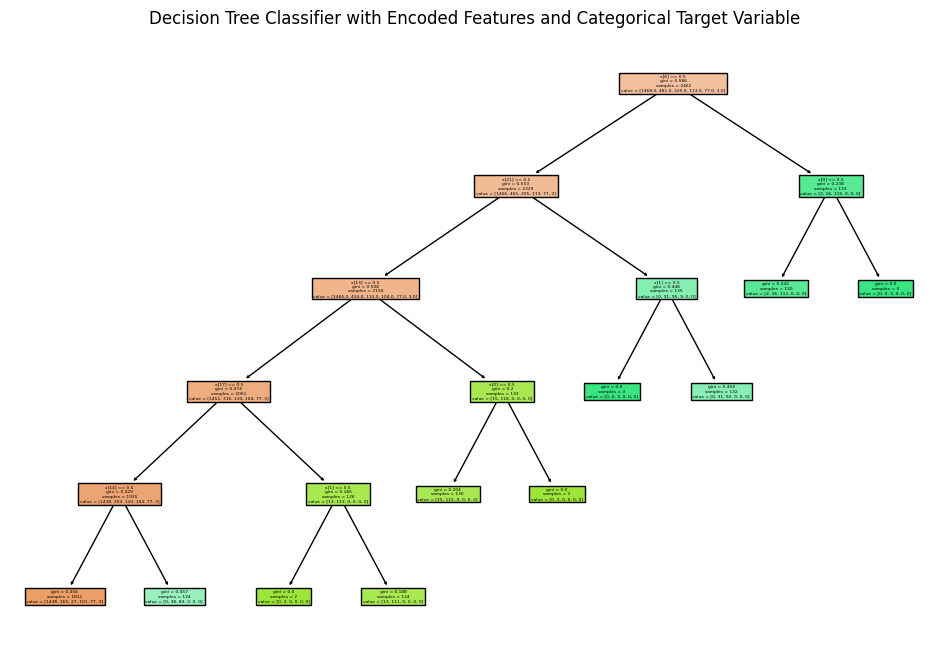

In [24]:
# Connect to MySQL database
conn = mysql.connector.connect(
    host="localhost",
    user="monty",
    password="sushiSQL",
    database="HealthCareAnalytics"
)

# Read the data from the MySQL table into a pandas DataFrame
query = "SELECT * FROM cms_chronic_conditions"
df = pd.read_sql(query, conn)
conn.close()

# Check the DataFrame and preprocess if needed (e.g., handle missing values)


# Define features and target variable
X = df[['Bene_Geo_Lvl', 'Bene_Age_Lvl', 'Bene_Demo_Lvl', 'Bene_Cond']]
y = df['Prvlnc']  # Assuming 'Prvlnc' is the target variable (you can adjust this)

# Perform one-hot encoding for categorical features
categorical_features = ['Bene_Geo_Lvl', 'Bene_Age_Lvl', 'Bene_Demo_Lvl', 'Bene_Cond']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_features)],
    remainder='passthrough'
)
X_encoded = preprocessor.fit_transform(X)

# Split data into training and testing sets with the encoded features
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Convert continuous target variable into categorical classes using binning
num_bins = 5  # Adjust the number of bins as needed
bin_edges = np.linspace(y_train.min(), y_train.max(), num_bins + 1)
y_train_categorical = np.digitize(y_train, bin_edges)
y_test_categorical = np.digitize(y_test, bin_edges)

# Train a decision tree classifier with the encoded features and categorical target variable
model = DecisionTreeClassifier(max_depth=5)  # Adjust hyperparameters as needed
model.fit(X_train, y_train_categorical)

# Make predictions using the test features
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_categorical, y_pred)
print(f"Accuracy: {accuracy}")

# Plot the decision tree with the encoded feature names
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True)
plt.title("Decision Tree Classifier with Encoded Features and Categorical Target Variable")
plt.show()

## CVD Cleaned